# Word Embeeding e LSTM

Quando os dados são textos, devemos de alguma forma transformar estes em vetores numéricos para que a maioria dos modelos possam ser treinados. Veremos algumas formas de vetorizar texto.

Utilizaremos dados do Twitter que podem ser baixados em:

- https://www.kaggle.com/datasets/kazanova/sentiment140
- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

In [2]:
import pandas as pd
import numpy as np

# texto
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize # Slow!
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modelo
from sklearn.naive_bayes import BernoulliNB

# métricas
from sklearn.metrics import classification_report

# utils
from collections import Counter
from sklearn.model_selection import train_test_split

# keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential

import warnings
warnings.filterwarnings('ignore')

In [140]:
df = pd.read_csv(
    "../datasets/Tweets/tweets.csv", encoding='latin-1',
    names=["Sentiment", "ID", "Date", "Query", "User", "Tweet"]
)
# df = df.sample(50000)
df.head(3)

,Sentiment,ID,Date,Query,User,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


## Limpeza de dados textuais

In [133]:
# removendo colunas desnecessárias
df.drop(['ID', 'Date', 'Query', 'User'], axis=1, inplace=True)

In [134]:
# deixando todos os caracteres minúsculos
df['Tweet'] = df['Tweet'].map(str.lower)

In [135]:
# removendo pontuações e marcações de usuários
def RemovePunctuation(x):
    x = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",x).split())
    return re.sub("["+string.punctuation+"]", r" ", x)
df['Tweet'] = df['Tweet'].map(RemovePunctuation)

In [136]:
# removendo números
def RemoveNumbers(x):
    res = re.sub(r'[0-9]+',r' ',x)
    return res
df['Tweet'] = df['Tweet'].map(RemoveNumbers)

In [137]:
# removendo stopwords
df['Tweet'] = df['Tweet'].map(remove_stopwords)

In [138]:
# removendo caracteres isolados
def removeSingleChars(text):
    words = text.split()
    return " ".join([w for w in words if len(w) > 1])
df['Tweet'] = df['Tweet'].map(removeSingleChars)

In [ ]:
### PULAR ###

# extraindo a raiz da palavra
# para português: # st = nltk.SnowballStemmer('portuguese')
# Lemmatization vs Stemmering (Lemma is a word)

st = PorterStemmer()
def stemming_on_text(data):
    data_split = data.split()
    text = [st.stem(word) for word in data_split]
    return text
df['Tweet']= df['Tweet'].map(stemming_on_text)

In [139]:
lm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    data_split = data.split()
    array = [lm.lemmatize(word) for word in data_split]
    text = " ".join(array)
    return text
df['Tweet'].map(lemmatizer_on_text)

176056                              think max cat gone
1367324                              glad friday night
1024054                          kee watch show comedy
651799                                            work
1577285                               bye awhile later
                              ...                     
127061                      minute studying exam today
806745     haha signed twitter go autoblogs great know
975142              prepare leave http plurk com uhijo
673932                                   ruehl closing
1286418                                     mean think
Name: Tweet, Length: 50000, dtype: object

In [ ]:
df.to_csv('../datasets/Tweets/clean_tweets.csv', index=None, encoding="utf-8")

## Limpando a memória

In [162]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             X: 434.9 MiB
                            df: 136.0 MiB
                             y: 15.3 MiB
                       y_train: 14.4 MiB
                     all_words:  8.0 MiB
                           _22:  6.0 MiB
                          _130:  6.0 MiB
                          _139:  4.9 MiB
                           _44:  3.6 MiB
                       x_train:  1.5 MiB


In [142]:
del df
del X_train_pad
del _43

## Continuando ...

# Vetorização com TF-IDF

In [143]:
df = pd.read_csv('../datasets/Tweets/clean_tweets.csv')
df = df.sample(1000000)
df.dropna(inplace=True)
X = df['Tweet']
y = df['Sentiment']
# del df
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558

In [144]:
%%time
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

CPU times: total: 18.7 s
Wall time: 22.3 s


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [145]:
%%time
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

CPU times: total: 10.8 s
Wall time: 13.1 s


In [147]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

CPU times: total: 297 ms
Wall time: 347 ms


BernoulliNB()

In [ ]:
y_pred = BNBmodel.predict(X_test)
print(classification_report(y_pred, y_test)) # 77%

              precision    recall  f1-score   support

           0       0.77      0.78      0.77     39447
           4       0.78      0.77      0.77     40033

    accuracy                           0.77     79480
   macro avg       0.77      0.77      0.77     79480
weighted avg       0.77      0.77      0.77     79480



## Vetorização com OneHot

In [152]:
df = pd.read_csv('../datasets/Tweets/clean_tweets.csv')
df.dropna(inplace=True)
df = df.sample(1000000)
X = df['Tweet']
y = df['Sentiment']

In [154]:
all_words = set()
for row in df['Tweet'].values:
    for word in row.split():
        all_words.add(word)
len(all_words)

234111

In [155]:
%%time
# não haverá unicidade com 500
# mesma palavra mesmo encoding (não considera contexto)
# vetor muito grande se unicidade
df["Tweet"] = df["Tweet"].map(lambda x: one_hot(x, 500))

CPU times: total: 6.53 s
Wall time: 7.6 s


In [156]:
df["Tweet"].head()

131081       [52, 180, 174, 60, 299, 243, 220, 396]
193446     [153, 258, 330, 439, 172, 361, 272, 451]
475614                  [395, 336, 60, 148, 10, 10]
1590455                          [410, 274, 31, 19]
1369221                   [348, 336, 215, 380, 490]
Name: Tweet, dtype: object

In [157]:
df["Tweet_count_words"] = df["Tweet"].map(len)
print(df['Tweet_count_words'].max(), df['Tweet_count_words'].min())

114 1


In [158]:
X = pad_sequences(
    df["Tweet"],
    maxlen=114,
    padding='post',
    truncating='post',
    value=0.0)
y = df['Sentiment']

In [161]:
X[:2, :20]

array([[ 52, 180, 174,  60, 299, 243, 220, 396,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [153, 258, 330, 439, 172, 361, 272, 451,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])

In [163]:
del df
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.05, random_state =42)

In [67]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred = BNBmodel.predict(X_test)
print(classification_report(y_pred, y_test)) # 50%

              precision    recall  f1-score   support

           0       0.62      0.50      0.56     30698
           4       0.39      0.51      0.44     19302

    accuracy                           0.51     50000
   macro avg       0.51      0.51      0.50     50000
weighted avg       0.53      0.51      0.51     50000



## Exercícios

Resolva o mesmo problema transformando textos com as duas técnicas abaixo:

Count vectorizing (1,2 Ngrams), Bag of words e One Hot Encoding N-Grams
- https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22

## Vetorização com Embeedings

https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer

In [164]:
df = pd.read_csv('../datasets/Tweets/clean_tweets.csv')
df.dropna(inplace=True)
df = df.sample(100000)
X = df['Tweet']
y = df['Sentiment'].map({0:0, 4:1})

In [165]:
all_words = set()
for row in df['Tweet'].values:
    for word in row.split():
        all_words.add(word)
len(all_words)

55968

In [166]:
df["Tweet_count_words"] = df["Tweet"].map(len)
print(df['Tweet_count_words'].max(), df['Tweet_count_words'].min())

274 2


In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.05, random_state =42)

In [168]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [169]:
word_index=tokenizer.word_index
vocab_size = len(word_index)+1

In [172]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [173]:
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [174]:
model = Sequential([
    Embedding(vocab_size, 20, input_length=maxlen),
    Bidirectional(LSTM(64)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compiles model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [175]:
%%time
model.fit(X_train_pad, y_train, batch_size=64, epochs=2, verbose=1)

Epoch 1/2
1485/1485 [==============================] - 106s 64ms/step - loss: 0.5383 - accuracy: 0.7289
Epoch 2/2
1485/1485 [==============================] - 94s 63ms/step - loss: 0.4353 - accuracy: 0.8027
CPU times: total: 2min 8s
Wall time: 3min 20s


In [176]:
y_pred = model.predict(X_test_pad)
print(classification_report(y_pred.ravel().round(0), y_test)) # 77%

157/157 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76      2615
         1.0       0.73      0.76      0.74      2385

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000



In [243]:
np.corrcoef(np.array([
    [2,2,5,6],
    [2,1,0,3],
    [5,1,-1,2]
]).ravel(), np.array([
    [1, 1.8,6,5],
    [2,1,1,4],
    [6,1,0,2]
]).ravel())

array([[1.        , 0.93474545],
       [0.93474545, 1.        ]])

- https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/

# Séries temporais com LSTM

In [177]:
import yfinance as yf
# modelo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import initializers, activations
from tensorflow.keras.layers import Activation
# transform
from sklearn.preprocessing import MinMaxScaler 
# utils
import math
import numpy as np
# eda
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

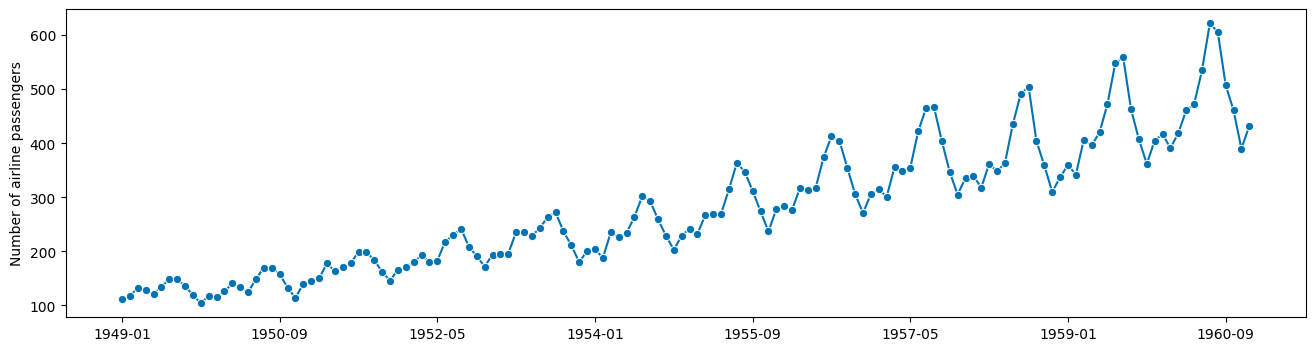

In [178]:
from sktime.datasets import load_airline
data = load_airline()
plot_series(data)
plt.show()

In [179]:
values = data.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

window_size = 60
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [180]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56, 60, 1), (28, 60, 1), (56,), (28,))

In [182]:
def get_model(x_train):
    model = Sequential([
        LSTM(80, 
             input_shape=(x_train.shape[1], x_train.shape[2]),
             return_sequences=True,
        ),
        LSTM(80, return_sequences=False),
        Dense(10),
        Dense(1)
    ])
    model.compile(optimizer="adam",loss='mean_squared_error',metrics=['mape'])
    return model

In [187]:
model = get_model(x_train)
history = model.fit(
    x_train, y_train, 
    batch_size= 1, 
    epochs=50,
    verbose=0)

In [184]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

1/1 [==============================] - 1s 1s/step
RMSE 27.672672816685267


In [185]:
result_df = pd.DataFrame({'pred': y_pred.ravel(), 'test': y_test.ravel()})
result_df.index = data[training_data_len:].index
y_pred = result_df['pred']
y_test = result_df['test']

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='pred'>)

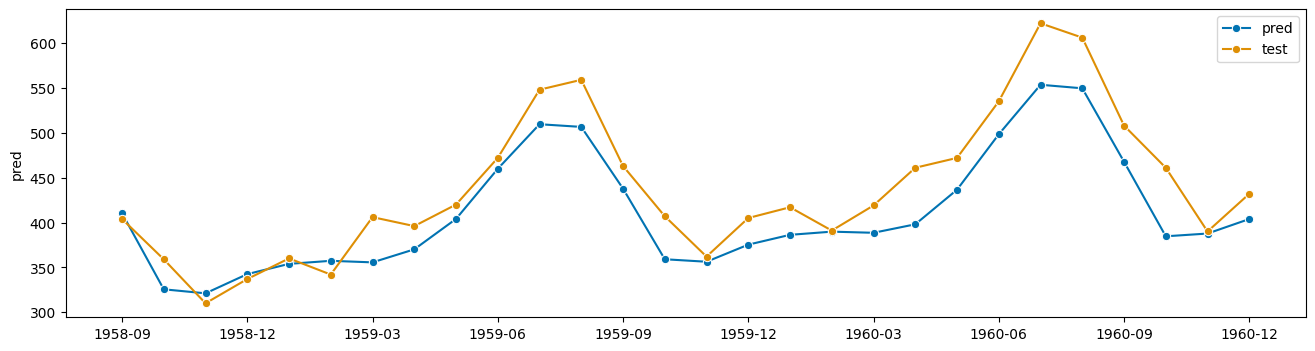

In [186]:
plot_series(y_pred, y_test, labels=['pred', 'test'])

## Mercado de ações: Endôgenea com LSTM

- https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [215]:
df = yf.download(
    'TAEE3.SA',
    start='2020-01-01',
    end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [216]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,10.29,10.42,10.01,10.11,7.206005,55500
2020-01-03,10.19,10.35,10.08,10.29,7.334302,39400
2020-01-06,10.28,10.43,10.14,10.34,7.369939,22200
2020-01-07,10.58,10.58,10.11,10.24,7.298663,36400
2020-01-08,10.26,10.30,10.10,10.24,7.298663,52700


<AxesSubplot: xlabel='Date'>

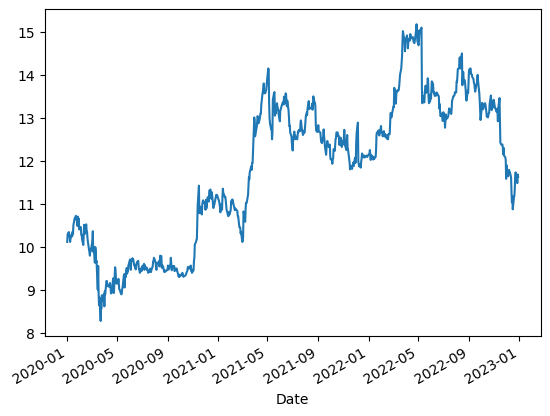

In [217]:
df['Close'].plot()

In [218]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [219]:
x_train.shape, x_test.shape, df.shape

((536, 60, 1), (149, 60, 1), (745, 6))

In [220]:
def get_model(x_train):
    model = Sequential([
        LSTM(100, 
             return_sequences=True, 
             activation="tanh", 
             input_shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(100, return_sequences=False, activation="tanh"),
        Dense(10),
        Dense(1)
    ])
    model.compile(optimizer="adam",loss='mean_squared_error',metrics=['mape'])
    return model

In [221]:
%%time
model = get_model(x_train)
model.fit(x_train, y_train, batch_size= 16, epochs=10)

Epoch 1/10
34/34 [==============================] - 4s 31ms/step - loss: 0.0392 - mape: 34.2475
Epoch 2/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0036 - mape: 13.9383
Epoch 3/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0026 - mape: 9.5634
Epoch 4/10
34/34 [==============================] - 1s 31ms/step - loss: 0.0025 - mape: 9.4333
Epoch 5/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0026 - mape: 9.7197
Epoch 6/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0023 - mape: 9.0230
Epoch 7/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0025 - mape: 9.2744
Epoch 8/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0023 - mape: 9.0375
Epoch 9/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0019 - mape: 8.4717
Epoch 10/10
34/34 [==============================] - 1s 31ms/step - loss: 0.0019 - mape: 8.3215
CPU times: total: 7.47 s
Wall time: 14.6 s


In [222]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

5/5 [==============================] - 1s 19ms/step
RMSE 0.033051145156757944


In [223]:
print("MAE", np.mean(abs(y_pred - y_test)))

MAE 0.8315761642710356


In [224]:
df.index = df.index.to_period(freq='D')
df.index

PeriodIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
             '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
             '2020-01-14', '2020-01-15',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
             '2022-12-28', '2022-12-29'],
            dtype='period[D]', name='Date', length=745)

In [225]:
df["Pred"] = 1
df["Pred"][len(train_data):] = y_pred.ravel()

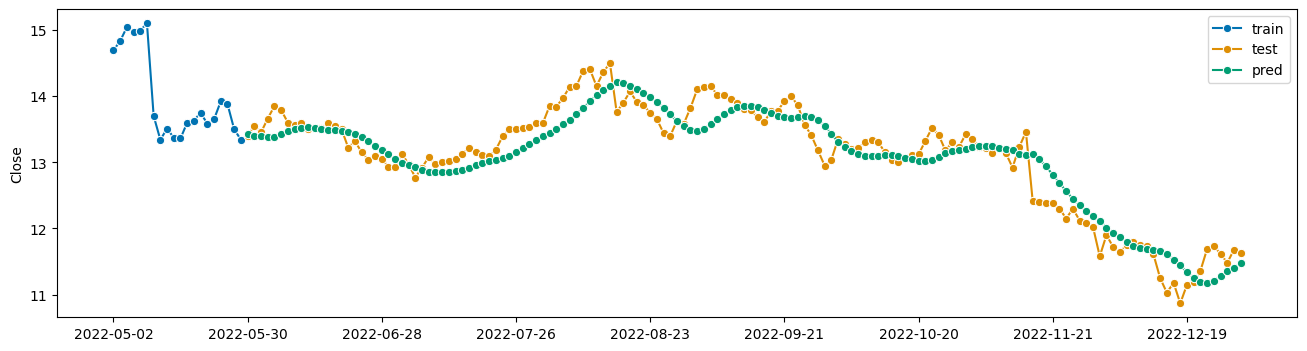

In [226]:
train = df.iloc[:len(train_data)]['Close']
test = df.iloc[len(train_data):]['Close']
pred = df.iloc[len(train_data):]['Pred']
plot_series(train[-20:], test, pred, labels=['train', 'test', 'pred'])
plt.show()

## Mercado de ações: Exôgeneas com LSTM

In [227]:
df = yf.download(
    'TAEE3.SA',
    start='2020-01-01',
    end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [228]:
data = df.drop(['Adj Close'], axis=1)
values = data.values
training_data_len = math.ceil(len(values)* 0.8)
window_size = 60

train_data = df[:training_data_len].copy()
test_data = df[training_data_len-window_size:].copy()

scalerx = MinMaxScaler(); 
scalery = MinMaxScaler();
xtrain_scaled = pd.DataFrame(scalerx.fit_transform(train_data), columns=train_data.columns)
ytrain_scaled = pd.DataFrame(scalery.fit_transform(train_data['Close'].values.reshape(-1,1)))
xtest_scaled = pd.DataFrame(scalerx.transform(test_data), columns=test_data.columns)
ytest_scaled = pd.DataFrame(scalery.transform(test_data['Close'].values.reshape(-1,1)))

x_train = []; y_train = []
for i in range(window_size, len(xtrain_scaled)):
    x_train.append(xtrain_scaled[i-window_size:i])
    y_train.append(ytrain_scaled[0][i])

x_test = []; y_test = []
for i in range(window_size, len(xtest_scaled)):
    x_test.append(xtest_scaled[i-window_size:i])
    y_test.append(ytest_scaled[0][i])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [111]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((536, 60, 6), (149, 60, 6), (536,), (149,))

In [229]:
model = get_model(x_train)
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
34/34 [==============================] - 4s 33ms/step - loss: 0.0220 - mape: 22.8239
Epoch 2/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0034 - mape: 11.2873
Epoch 3/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0025 - mape: 9.3284
Epoch 4/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0021 - mape: 8.9953
Epoch 5/10
34/34 [==============================] - 1s 35ms/step - loss: 0.0019 - mape: 8.4654
Epoch 6/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0017 - mape: 8.2145
Epoch 7/10
34/34 [==============================] - 1s 32ms/step - loss: 0.0017 - mape: 8.2239
Epoch 8/10
34/34 [==============================] - 1s 35ms/step - loss: 0.0016 - mape: 7.9225
Epoch 9/10
34/34 [==============================] - 1s 35ms/step - loss: 0.0020 - mape: 8.6739
Epoch 10/10
34/34 [==============================] - 1s 33ms/step - loss: 0.0017 - mape: 8.0703


In [230]:
y_pred = model.predict(x_test)
y_pred = scalery.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

5/5 [==============================] - 1s 18ms/step
RMSE 12.422649977046525


In [231]:
print("MAE", np.mean(abs(y_pred - y_test)))

MAE 12.422649977046525


In [232]:
df.index = df.index.to_period(freq='D')
df.index

PeriodIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
             '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
             '2020-01-14', '2020-01-15',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
             '2022-12-28', '2022-12-29'],
            dtype='period[D]', name='Date', length=745)

In [233]:
df["Pred"] = 1
df["Pred"][len(train_data):] = y_pred.ravel()

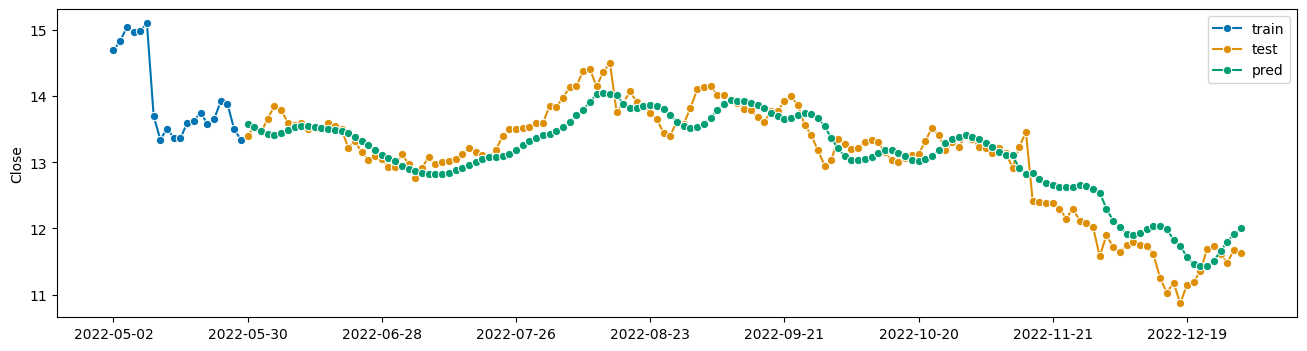

In [234]:
train = df.iloc[:len(train_data)]['Close']
test = df.iloc[len(train_data):]['Close']
pred = df.iloc[len(train_data):]['Pred']
plot_series(train[-20:], test, pred, labels=['train', 'test', 'pred'])
plt.show()

# Atividade avaliativa

Faça uma submissão no desafio https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/submissions

- **Meta 10**: 0.4
- **Meta 07**: 1.2
- **Meta 04**: 7
- **Meta 00**: >= 18